In [ ]:
#Nama : Nabilah Salwa
#NIM  : 1103204060

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [9]:
df = pd.read_csv('/content/drive/MyDrive/traffic sign data/signname.csv')

In [14]:
#Membuka file-file data latih dan data uji
training_file = "/content/drive/MyDrive/traffic sign data/train.p"
testing_file = "/content/drive/MyDrive/traffic sign data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [15]:
#Membaca file CSV yang berisi informasi tentang nama kelas atau tanda-tanda
sign_name_df = pd.read_csv('/content/drive/MyDrive/traffic sign data/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [16]:
#Mengatur gaya Matplotlib menjadi 'ggplot'
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
# Define features and labels for training data
X, y = train['features'], train['labels']

# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [18]:
#Mengambil fitur dari data train
X, y = train['features'], train['labels']

In [19]:
#Mengubah data fitur dari format list kedalam array numpy
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

(34799, 32, 32, 3) (34799,)


In [20]:
#Mengambil fitur data test
X_test, y_test = test['features'], test['labels']

In [21]:
#Mengubah data fitur dari format list kedalam array numpy
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


In [22]:
#Membagi dataset menjadi data train dan data test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


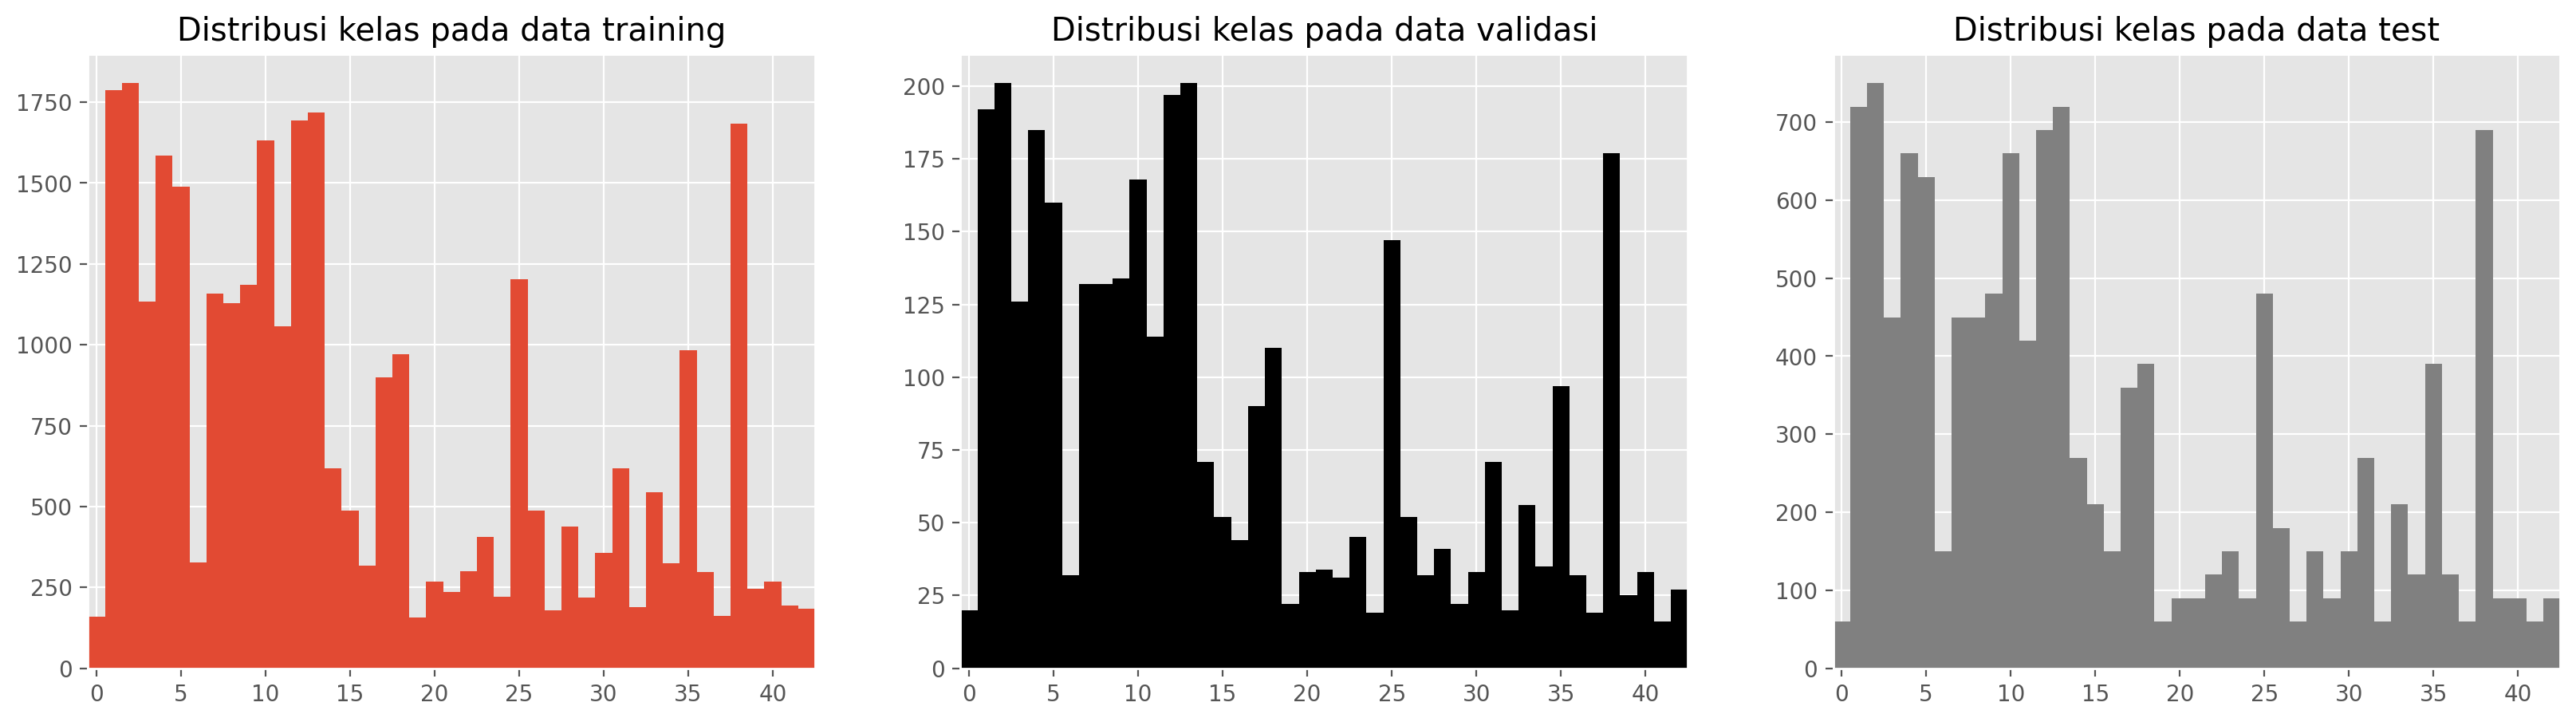

In [23]:
#Membuat histogram
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [24]:
#Mengonversi label kelas dari format integer ke dalam format one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

In [26]:
#Mendefinisikan arsitektur sebuah model neural network
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [27]:
#Memberikan gambaran ringkas tentang arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [28]:
#Mengonfigurasi proses pelatihan pada model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
#Melatih model menggunakan data latih sekama 25 epoch
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 147s 149ms/step - loss: 1.5866 - accuracy: 0.5970 - val_loss: 0.2716 - val_accuracy: 0.9322
Epoch 2/25
979/979 [==============================] - 147s 150ms/step - loss: 0.4408 - accuracy: 0.8708 - val_loss: 0.1056 - val_accuracy: 0.9733
Epoch 3/25
979/979 [==============================] - 141s 144ms/step - loss: 0.2951 - accuracy: 0.9145 - val_loss: 0.0999 - val_accuracy: 0.9724
Epoch 4/25
979/979 [==============================] - 143s 146ms/step - loss: 0.2580 - accuracy: 0.9255 - val_loss: 0.0930 - val_accuracy: 0.9790
Epoch 5/25
979/979 [==============================] - 144s 147ms/step - loss: 0.2322 - accuracy: 0.9338 - val_loss: 0.0685 - val_accuracy: 0.9845
Epoch 6/25
979/979 [==============================] - 148s 152ms/step - loss: 0.2143 - accuracy: 0.9402 - val_loss: 0.0631 - val_accuracy: 0.9859
Epoch 7/25
979/979 [==============================] - 139s 142ms/step - loss: 0.1929 - accuracy: 0.9455 - val_loss: 0.0718 -

In [30]:
#Menyimpan model neural network yang telah dilatih ke file dengan format HDF5
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


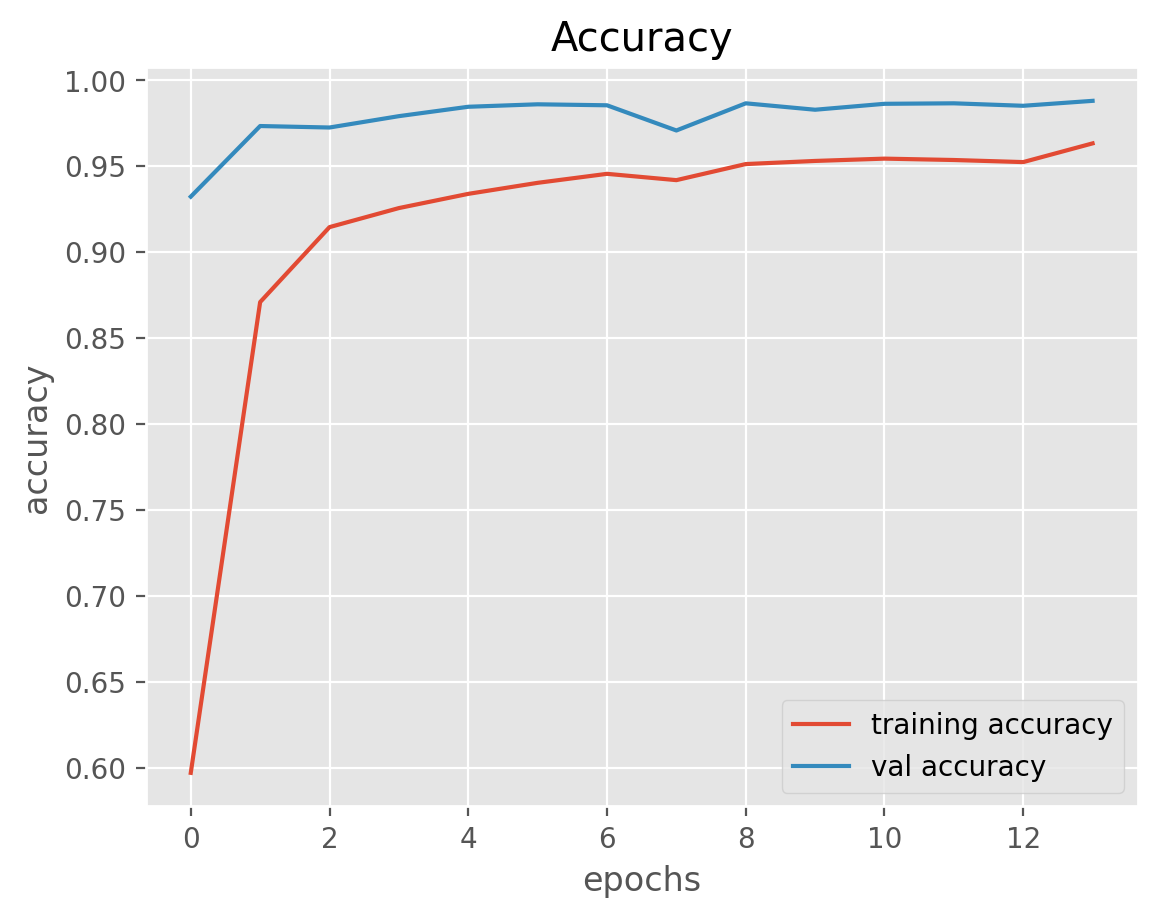

In [31]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

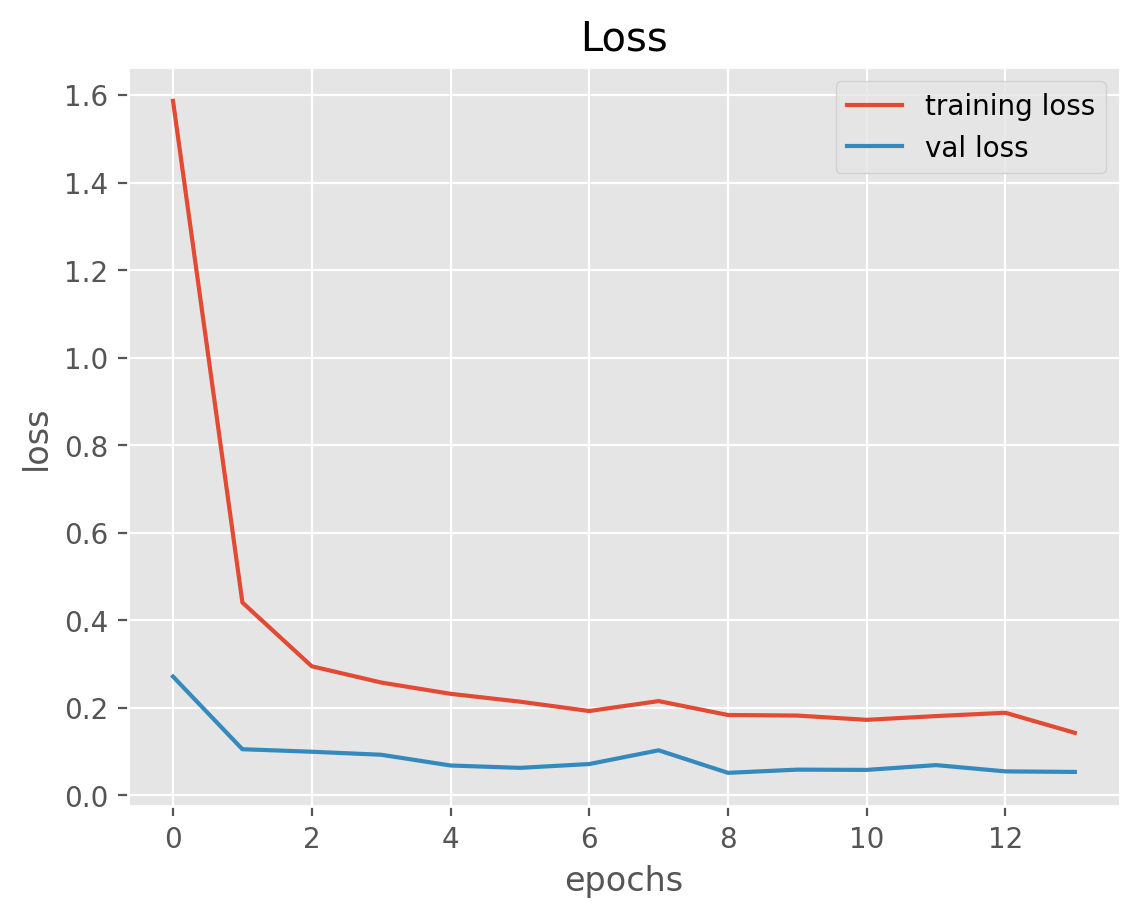

In [32]:
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [33]:
#Preiksi terhadap data uji
pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 16s 39ms/step


0.9552652414885194